# Uncertainty analysis 

In [1]:
from utils import *
import itertools
import pandas as pd
import os
import numpy as np
import warnings

from utils.plots import *
from utils.SA_utils import SA

warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.set_option('display.max_columns', None)

c:\Users\gmendoza\AppData\Local\anaconda3\Lib\site-packages\resipy\meshTools.py:56: UserWarning: pyvista not installed, 3D meshing viewing options will be limited
  warnings.warn('pyvista not installed, 3D meshing viewing options will be limited')


API path =  c:\Users\gmendoza\AppData\Local\anaconda3\Lib\site-packages\resipy
ResIPy version =  3.5.4
cR2.exe found and up to date.
R3t.exe found and up to date.
cR3t.exe found and up to date.


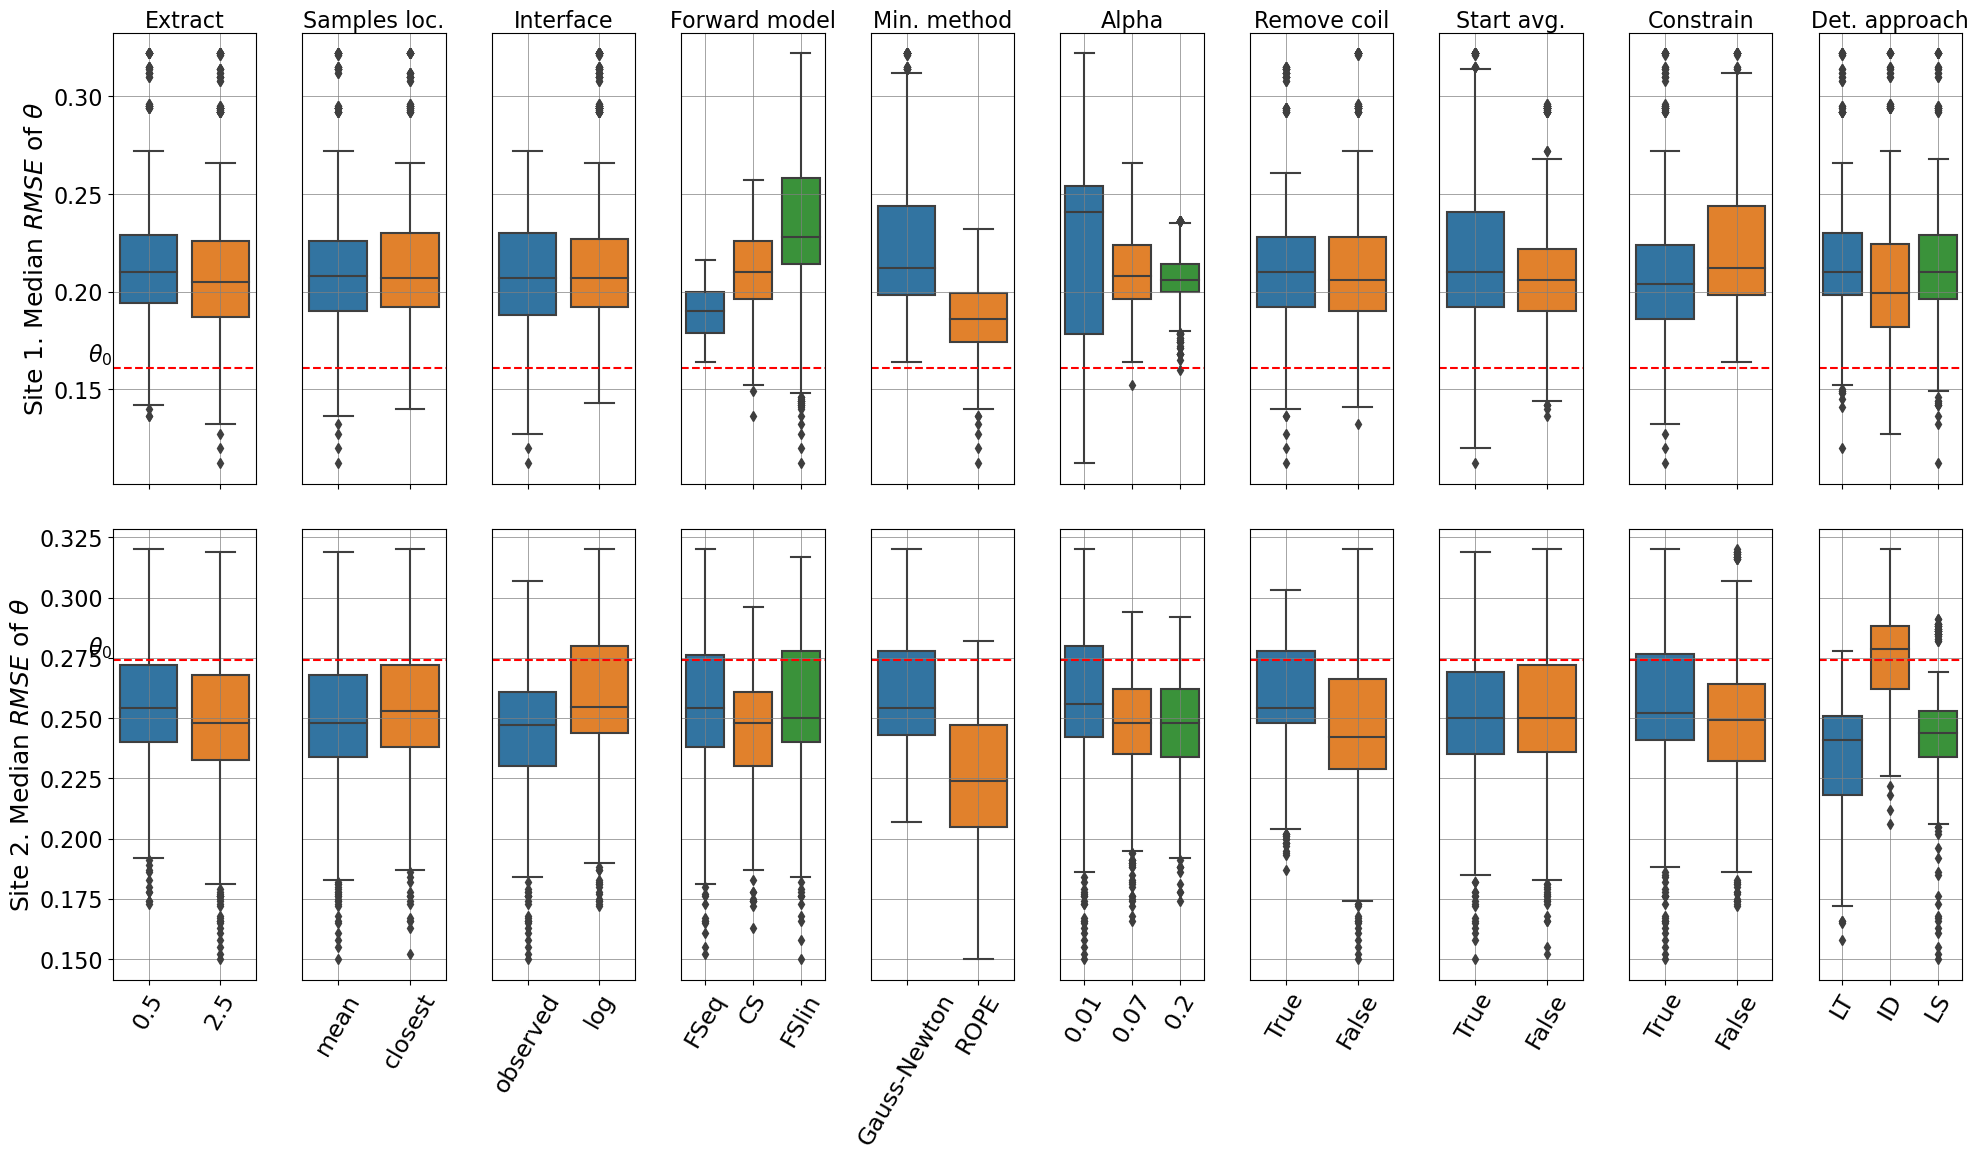

In [4]:
# Define the variables and their possible values
site = 'P'

extracts = [0.5, 2.5]
sample_locs = ['mean', 'closest']
interfaces = ['observed', 'log']
FMs = ['FSeq', 'CS', 'FSlin']
MinMs = ['Gauss-Newton', 'ROPE']
alphas = [0.01, 0.07, 0.2]
remove_coils = [True, False]
start_avgs = [True, False]
constrains = [True, False]

SA_results = 'data/SA_results/'

file_path = str(extracts)+'_'+str(sample_locs)+'_'+str(['obs', 'log'])+'_'+str(FMs)+'_'+str(['GN', 'ROPE'])+'_'+str(alphas)+'_'+str(['T', 'F'])+'_'+str(['T', 'F'])+'_'+str(['T', 'F'])+'_det'
file_path_all_site = 'dt'+site+'_'+file_path

# Initialize DataFrame
dt = pd.DataFrame()
i = 0  # to keep track of iterations for saving purposes
exist_fine = 0 
exist_failed = 0
new_fine = 0
new_failed = 0
exist_crash = 0
new_crash = 0


if not os.path.exists(SA_results + file_path_all_site+'.csv'):


    # Iterate over all combinations
    for combination in itertools.product(extracts, sample_locs, interfaces, FMs, MinMs, alphas, remove_coils, start_avgs, constrains):

        extract, sample_loc, interface, FM, MinM, alpha, remove_coil, start_avg, constrain = combination
        print('Iteration:', i, 'Combination:', combination)

        file_path = 'dt'+site+'_'+str(extract)+'_'+str(sample_loc)+'_'+str(interface)+'_'+str(FM)+'_'+str(MinM)+'_'+str(alpha)+'_'+str(remove_coil)+'_'+str(start_avg)+'_'+str(constrain)+'_det'
        SA_file_path = SA_results + file_path+'.csv'
        file_path_FAILED = SA_results + file_path+'_FAILED'+'.csv'
        file_path_CRASH = SA_results + file_path+'_CRASH'+'.csv'

        if os.path.exists(SA_file_path):
            print('exists')
            SA_file = pd.read_csv(SA_file_path)
            exist_fine += 1

        elif os.path.exists(file_path_FAILED):
            print('exists but failed')
            SA_file = pd.read_csv(file_path_FAILED)
            exist_failed += 1

        elif os.path.exists(file_path_CRASH):
            print('exists but crashed')
            SA_file = pd.read_csv(file_path_CRASH)
            exist_crash += 1

        else:
            try:
                # Call the SA function with the current combination
                results = SA(site, extract, sample_loc, interface, FM, MinM, alpha, remove_coil, start_avg, constrain)

                if results is None:
                    # Create a dictionary for the current iteration's results
                    current_results = [{'Extract': extract, 'Samples loc.': sample_loc, 'Interface': interface, 'Forward model': FM, 'Min. method': MinM, 'Alpha': alpha,
                                        'Remove coil': remove_coil, 'Start avg.': start_avg, 'Constrain': constrain,
                                    'Det. approach': det, 'R2': np.nan, 'RMSE': np.nan, 'MAE': np.nan, 'STD': np.nan, '0R2': np.nan, '0RMSE': np.nan, 'R2_INV': np.nan}
                                for det, res in zip(['LT', 'ID', 'LS'], [(np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan) for i in range(0, 6, 2)])]
                    
                    print('FAILED')
                    SA_file = pd.DataFrame(current_results)
                    #print(f"An error occurred: {e} with combination {combination}")
                    SA_file.to_csv(file_path_FAILED, index=False)
                    new_failed += 1

                else: 
                    # Create a dictionary for the current iteration's results
                    current_results = [{'Extract': extract, 'Samples loc.': sample_loc, 'Interface': interface, 'Forward model': FM, 'Min. method': MinM, 'Alpha': alpha,
                                        'Remove coil': remove_coil, 'Start avg.': start_avg, 'Constrain': constrain,
                                    'Det. approach': det, 'R2': res[0], 'RMSE': res[1], 'MAE': res[2], 'STD': res[3], '0R2': res[4], '0RMSE': res[5], 'R2_INV': res[6]}
                                    for det, res in zip(['LT', 'ID', 'LS'], [(results[i], results[i+1], results[i+16], results[i+17], results[i+10], results[i+11], results[-1]) for i in range(0, 6, 2)])]

                    print('current_results', current_results)
                    SA_file = pd.DataFrame(current_results)
                    # Save the DataFrame to CSV after each iteration
                    SA_file.to_csv(SA_file_path, index=False)
                    #os.remove(file_path_FAILED)
                    new_fine += 1

            except Exception as e:
                # Create a dictionary for the current iteration's results
                current_results = [{'Extract': extract, 'Samples loc.': sample_loc, 'Interface': interface, 'Forward model': FM, 'Min. method': MinM, 'Alpha': alpha,
                                        'Remove coil': remove_coil, 'Start avg.': start_avg, 'Constrain': constrain,
                                    'Det. approach': det, 'R2': np.nan, 'RMSE': np.nan, 'MAE': np.nan, 'STD': np.nan, '0R2': np.nan, '0RMSE': np.nan, 'R2_INV': np.nan}
                                for det, res in zip(['LT', 'ID', 'LS'], [(np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan) for i in range(0, 6, 2)])]
                
                print('CRASH')
                SA_file = pd.DataFrame(current_results)
                #print(f"An error occurred: {e} with combination {combination}")
                SA_file.to_csv(file_path_CRASH, index=False)
                new_crash += 1

                continue  # Continue to the next iteration even if an error occurs

        # Append current results to the DataFrame
        dt = pd.concat([dt, SA_file])
        i += 1  # Increment the iteration counter

    print(dt)
    dt.to_csv(SA_results + file_path_all_site+'.csv')

indicator = 'RMSE'
SA_plot(file_path, SA_results, indicator)